In [22]:
%pip install torch torchvision matplotlib tqdm tensorboard

You should consider upgrading via the '/Users/antoinebendafi/Sites/localhost/A5/spe-ia-machine-learning/vae_env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [23]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
from tensorboard import program

writer = SummaryWriter(log_dir="runs/vae_training")
logdir = os.path.join(os.getcwd(), "runs", "vae_training")
tb = program.TensorBoard()
tb.configure(argv=[None, '--logdir', logdir, '--bind_all'])
url = tb.launch()
print(f"TensorBoard est disponible à l'adresse : {url}")


TensorBoard est disponible à l'adresse : http://MacBook-Pro-de-AntoineBendafi.local:6011/


In [24]:
transform = transforms.Compose([
    transforms.ToTensor(), 
])

batch_size = 64
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("Dataset prêt et chargé avec succès !")


Dataset prêt et chargé avec succès !


In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encodeur
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Décodeur
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 28 * 28),
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z).view(-1, 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, logvar


In [ ]:
latent_dim = 50
lr = 1e-3
epochs = 50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE(latent_dim).to(device)


optimizer = optim.Adam(vae.parameters(), lr=lr)

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.BCELoss()(recon_x, x) 
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + 0.01 * kld_loss 


In [27]:
def visualize_reconstruction(model, data_loader, epoch, num_images=8):
    model.eval()
    with torch.no_grad():
        images, _ = next(iter(data_loader))
        images = images.to(device)
        recon_images, _, _ = model(images)
        
        # Transformation pour afficher les images
        images = images.cpu().numpy()
        recon_images = recon_images.cpu().numpy()

        fig, axs = plt.subplots(2, num_images, figsize=(15, 4))
        for i in range(num_images):
            # Images originales
            axs[0, i].imshow(images[i, 0], cmap='gray')
            axs[0, i].axis('off')

            # Images reconstruites
            axs[1, i].imshow(recon_images[i, 0], cmap='gray')
            axs[1, i].axis('off')
        
        plt.suptitle(f"Reconstructions à l'époque {epoch + 1}")
        plt.show()
    model.train()


100%|██████████| 938/938 [00:14<00:00, 64.75it/s]


[Epoch 1/50] Loss: 0.2575


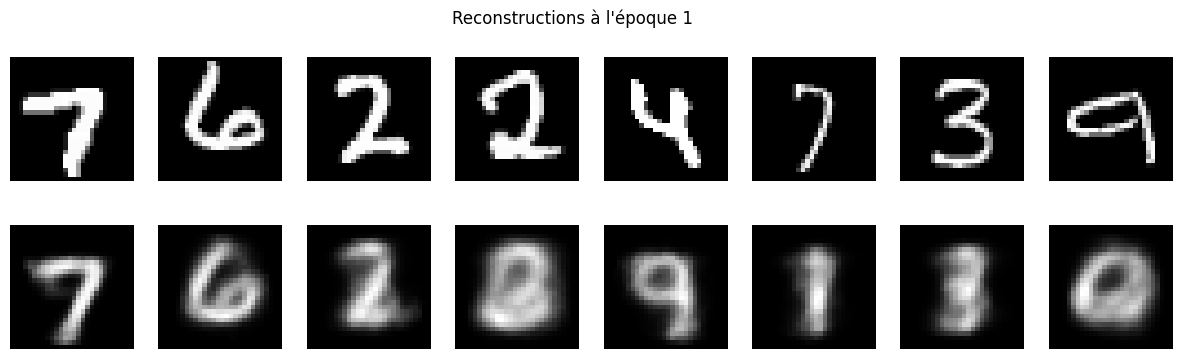

100%|██████████| 938/938 [00:12<00:00, 72.35it/s]


[Epoch 2/50] Loss: 0.2395


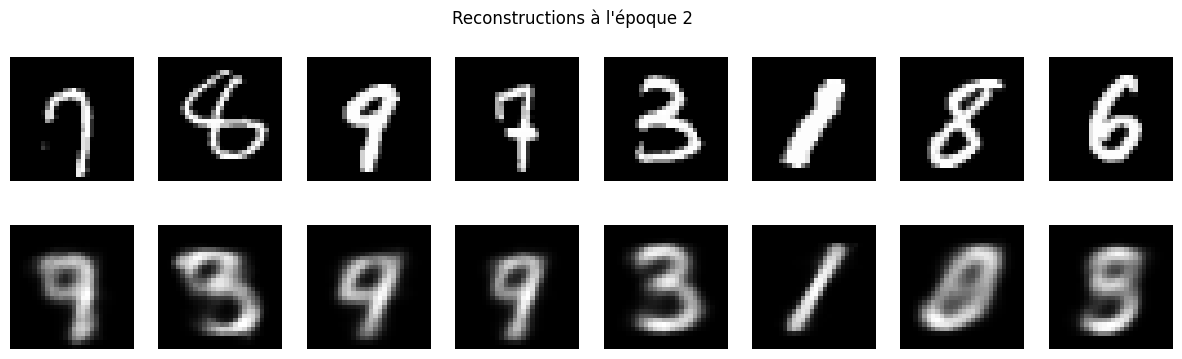

100%|██████████| 938/938 [00:12<00:00, 74.33it/s]


[Epoch 3/50] Loss: 0.2339


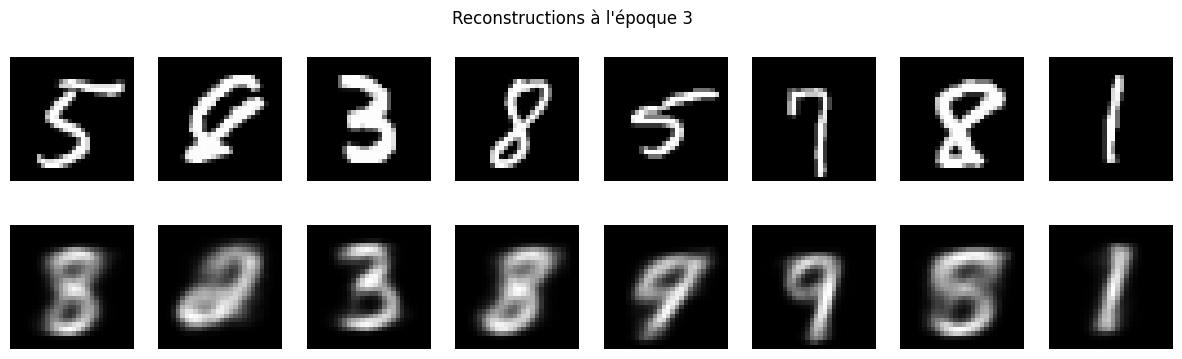

100%|██████████| 938/938 [00:12<00:00, 72.37it/s]


[Epoch 4/50] Loss: 0.2320


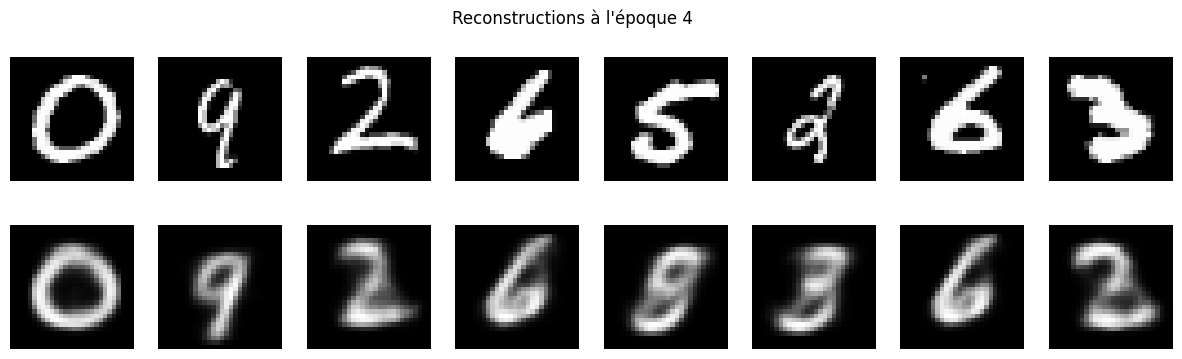

100%|██████████| 938/938 [00:17<00:00, 54.95it/s]


[Epoch 5/50] Loss: 0.2307


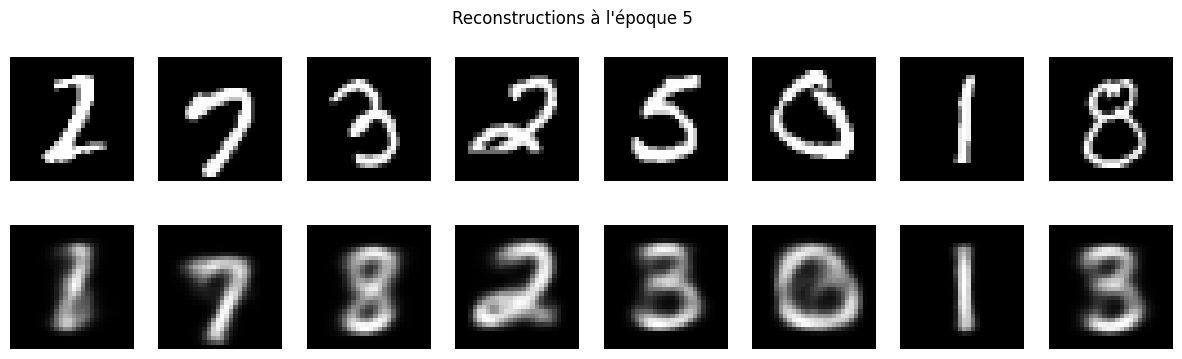

100%|██████████| 938/938 [00:13<00:00, 71.51it/s]


[Epoch 6/50] Loss: 0.2304


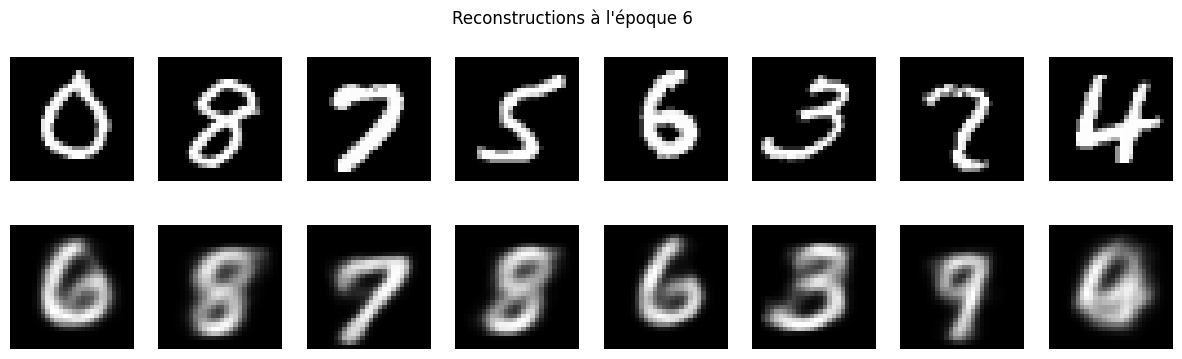

100%|██████████| 938/938 [00:18<00:00, 49.63it/s]


[Epoch 7/50] Loss: 0.2297


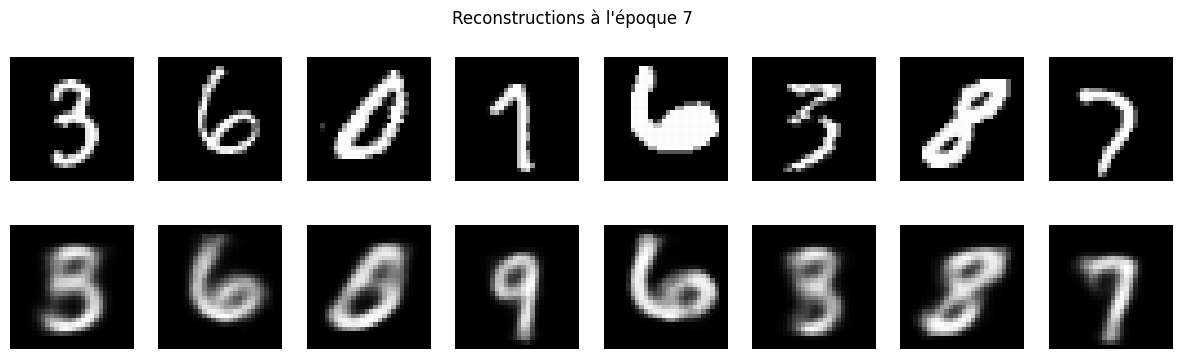

100%|██████████| 938/938 [00:14<00:00, 65.14it/s]


[Epoch 8/50] Loss: 0.2293


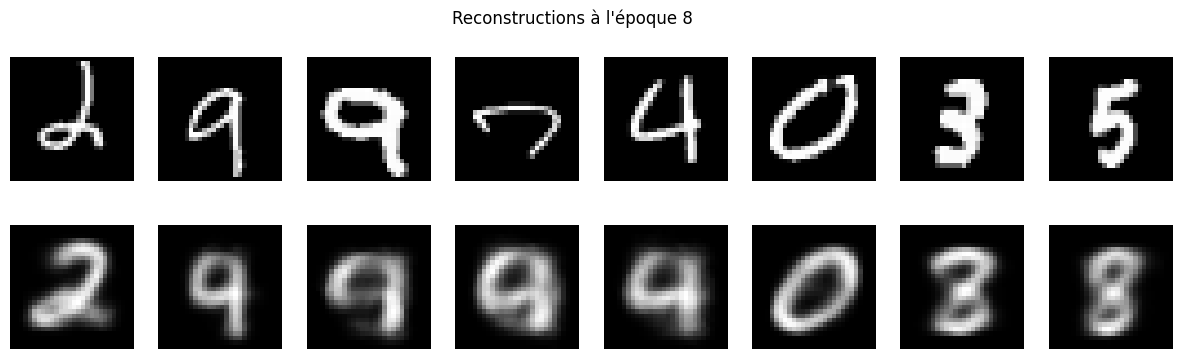

100%|██████████| 938/938 [00:12<00:00, 73.08it/s]


[Epoch 9/50] Loss: 0.2288


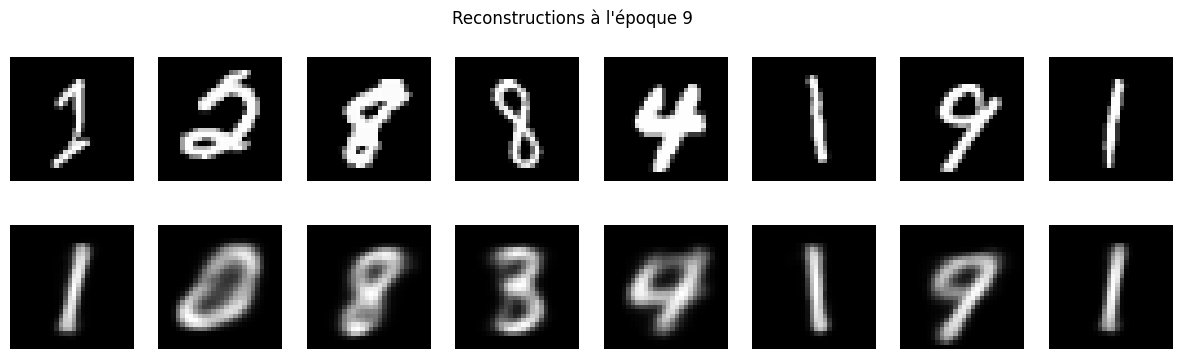

100%|██████████| 938/938 [00:12<00:00, 74.80it/s]


[Epoch 10/50] Loss: 0.2288


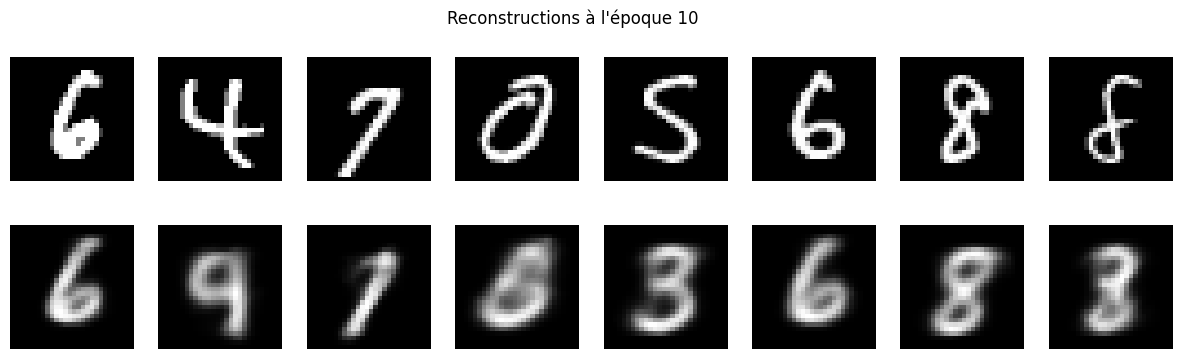

100%|██████████| 938/938 [00:11<00:00, 78.18it/s]


[Epoch 11/50] Loss: 0.2284


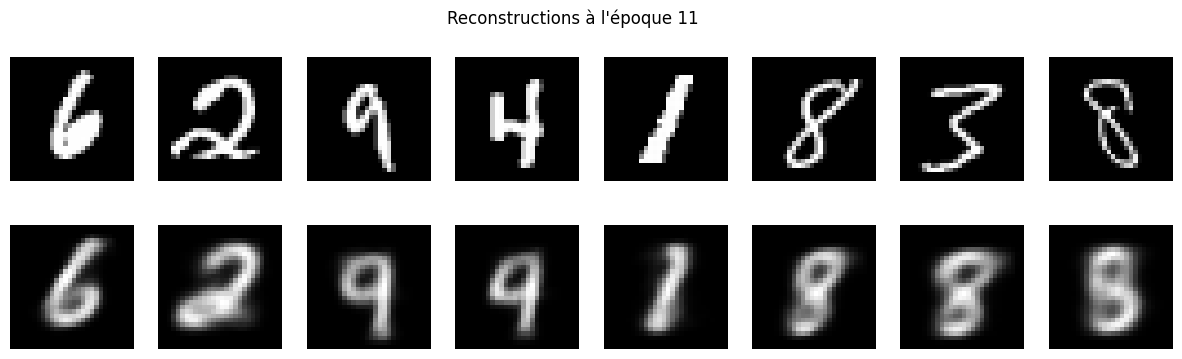

100%|██████████| 938/938 [00:11<00:00, 79.41it/s]


[Epoch 12/50] Loss: 0.2284


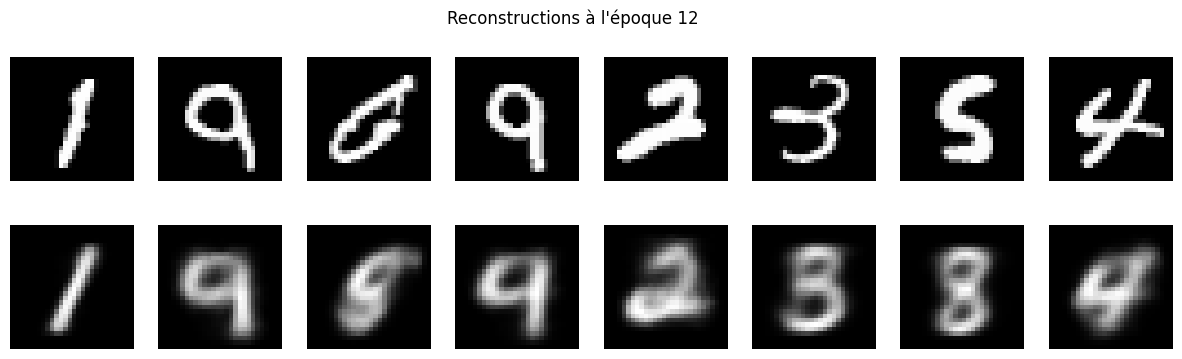

100%|██████████| 938/938 [00:11<00:00, 79.61it/s]


[Epoch 13/50] Loss: 0.2282


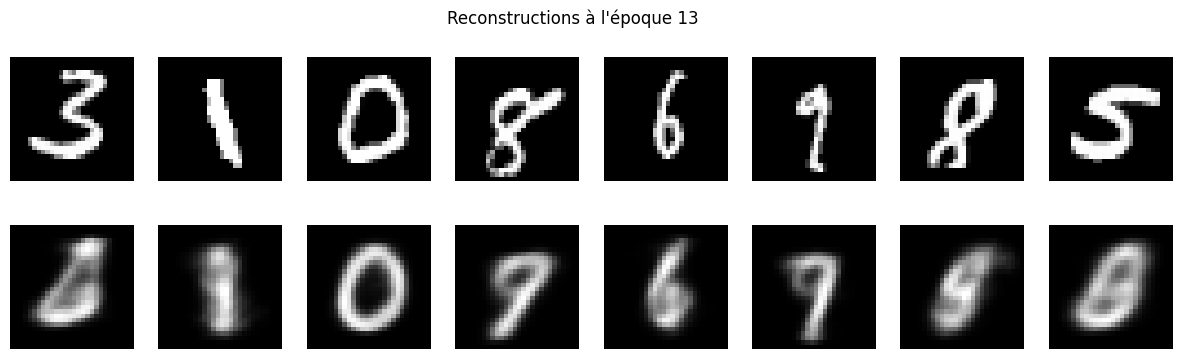

100%|██████████| 938/938 [00:12<00:00, 77.09it/s]


[Epoch 14/50] Loss: 0.2284


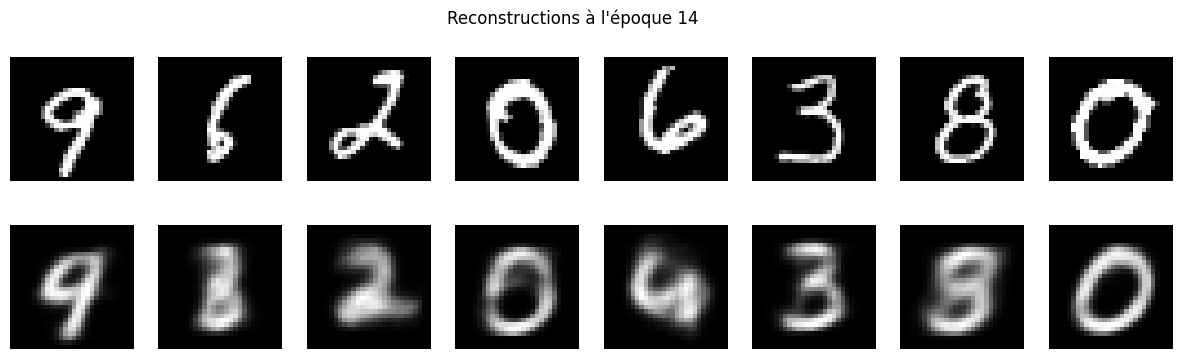

100%|██████████| 938/938 [00:13<00:00, 68.19it/s]

[Epoch 15/50] Loss: 0.2277


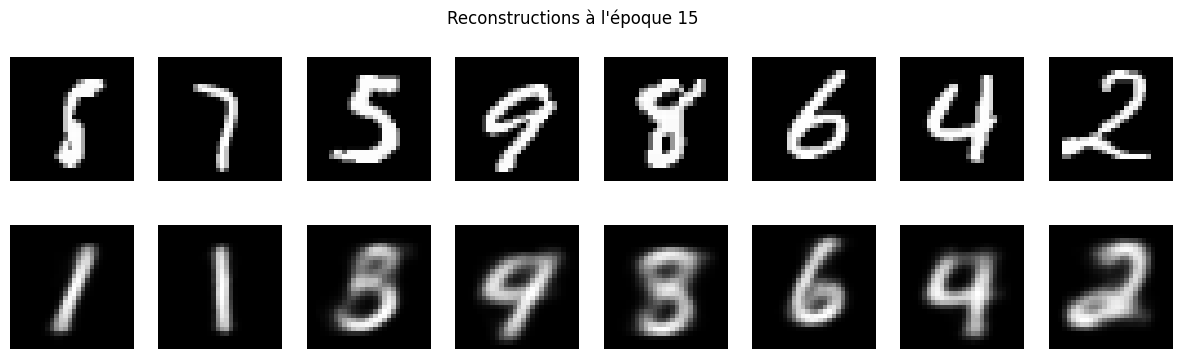

100%|██████████| 938/938 [00:13<00:00, 71.37it/s]


[Epoch 16/50] Loss: 0.2276


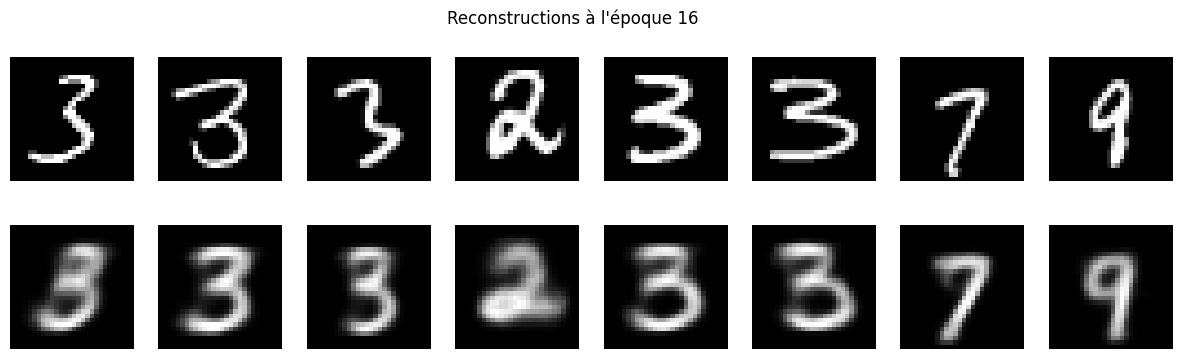

100%|██████████| 938/938 [00:12<00:00, 75.49it/s]


[Epoch 17/50] Loss: 0.2274


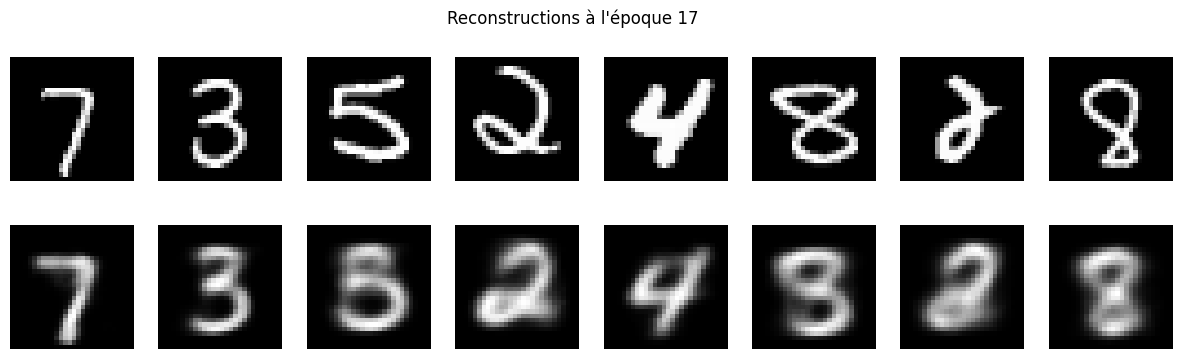

100%|██████████| 938/938 [00:11<00:00, 78.27it/s]


[Epoch 18/50] Loss: 0.2275


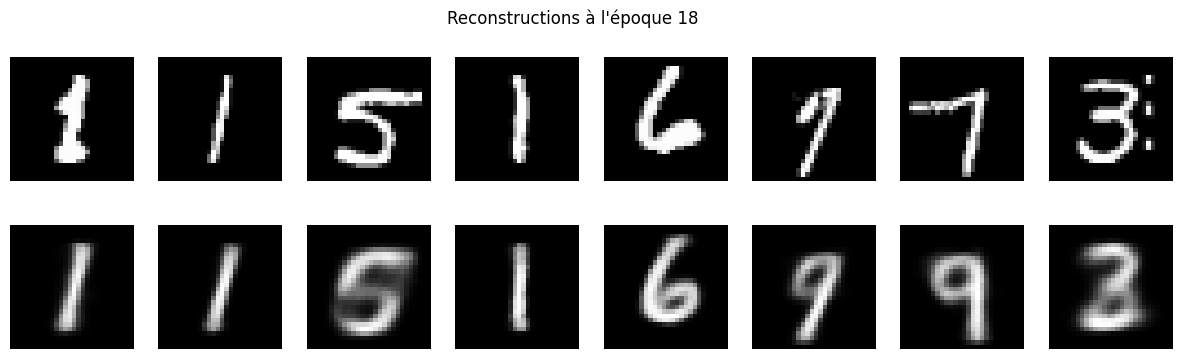

100%|██████████| 938/938 [00:11<00:00, 79.47it/s]


[Epoch 19/50] Loss: 0.2277


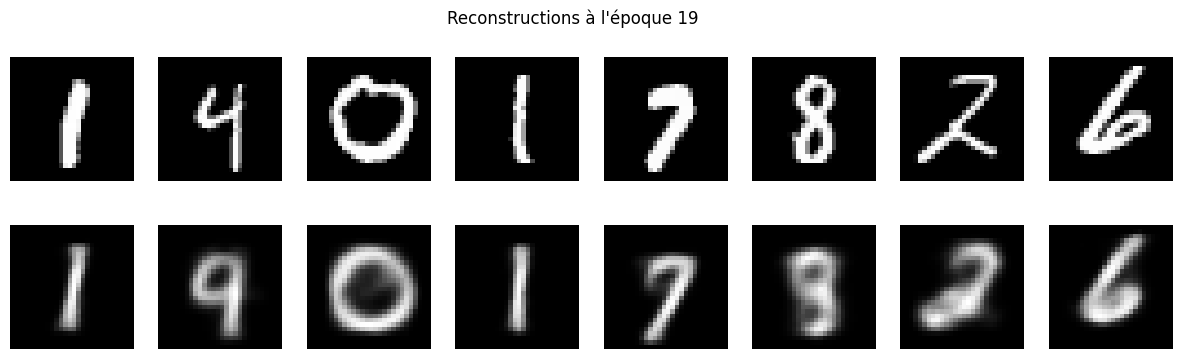

100%|██████████| 938/938 [00:13<00:00, 71.76it/s]


[Epoch 20/50] Loss: 0.2275


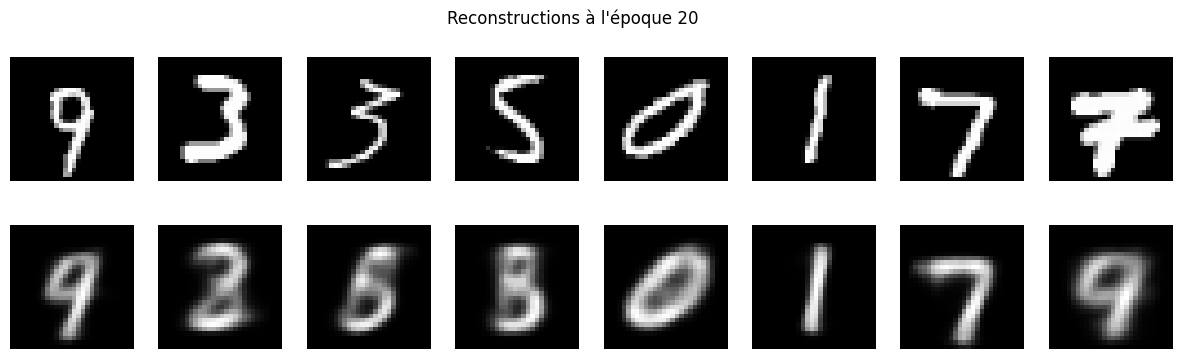

100%|██████████| 938/938 [00:14<00:00, 64.56it/s]


[Epoch 21/50] Loss: 0.2273


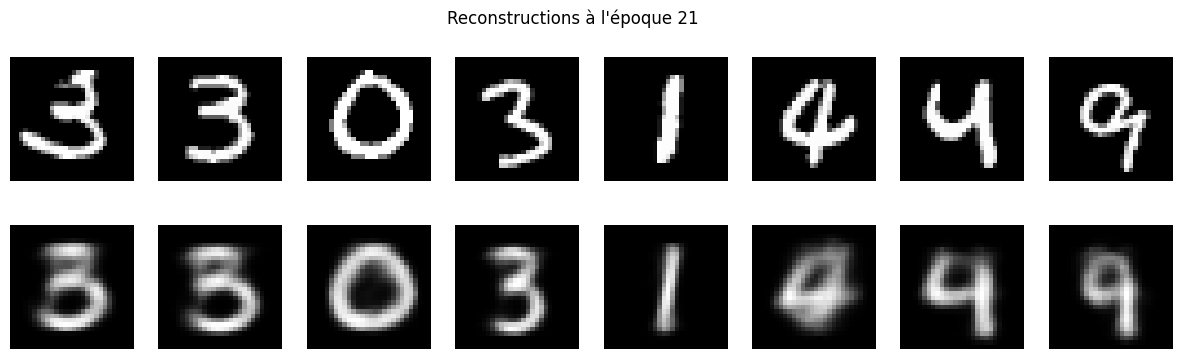

100%|██████████| 938/938 [00:12<00:00, 75.98it/s]


[Epoch 22/50] Loss: 0.2273


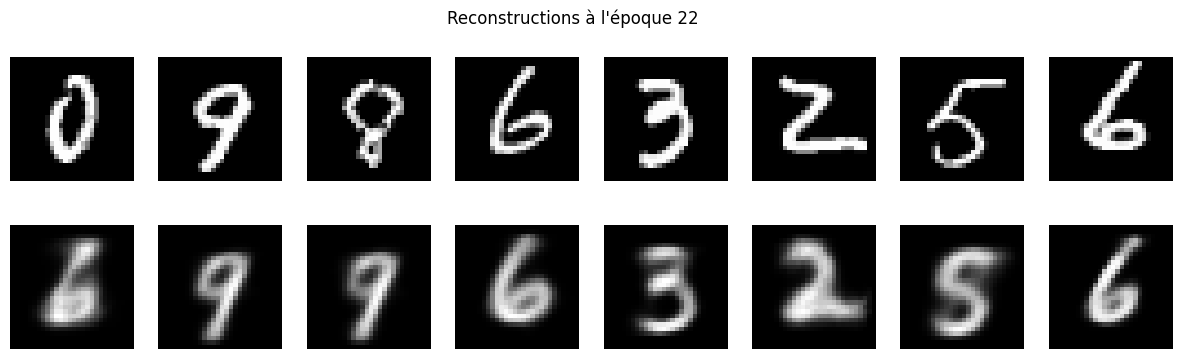

100%|██████████| 938/938 [00:11<00:00, 78.41it/s]


[Epoch 23/50] Loss: 0.2270


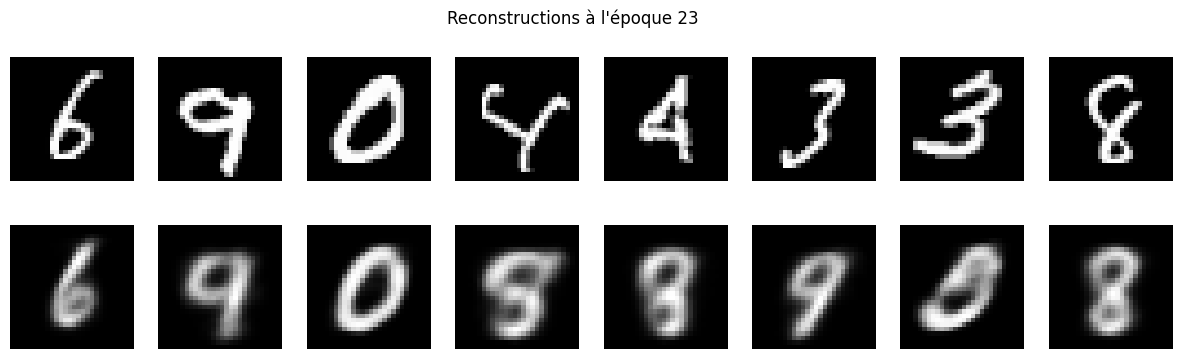

100%|██████████| 938/938 [00:11<00:00, 78.58it/s]


[Epoch 24/50] Loss: 0.2271


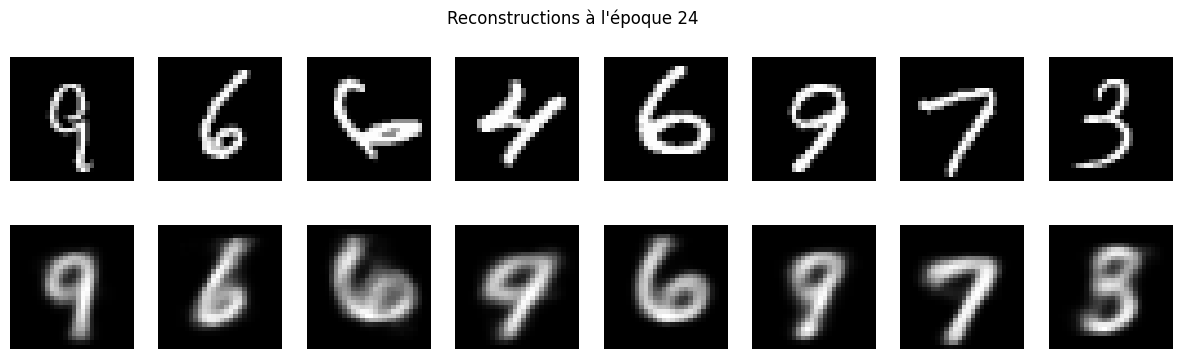

100%|██████████| 938/938 [00:11<00:00, 80.74it/s]


[Epoch 25/50] Loss: 0.2270


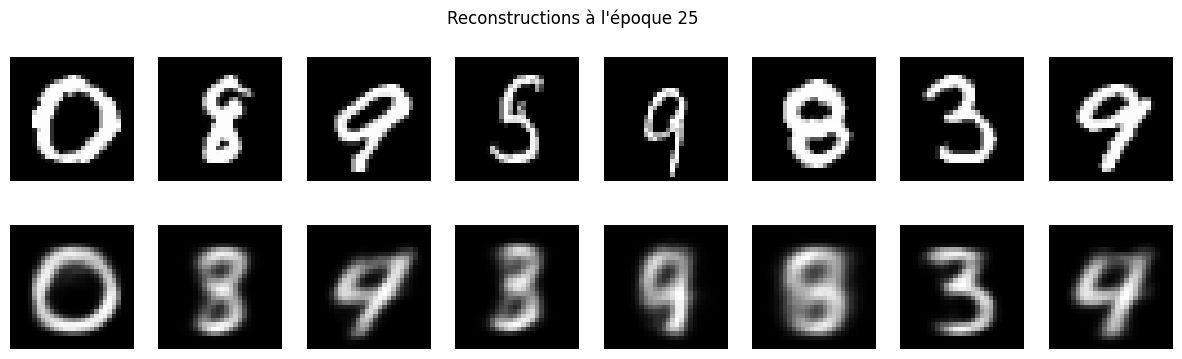

100%|██████████| 938/938 [00:11<00:00, 79.87it/s]


[Epoch 26/50] Loss: 0.2267


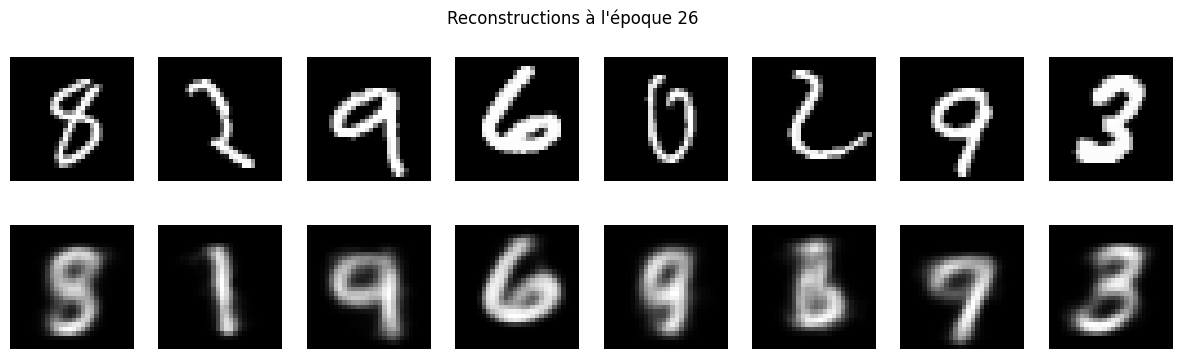

100%|██████████| 938/938 [00:14<00:00, 65.62it/s]


[Epoch 27/50] Loss: 0.2269


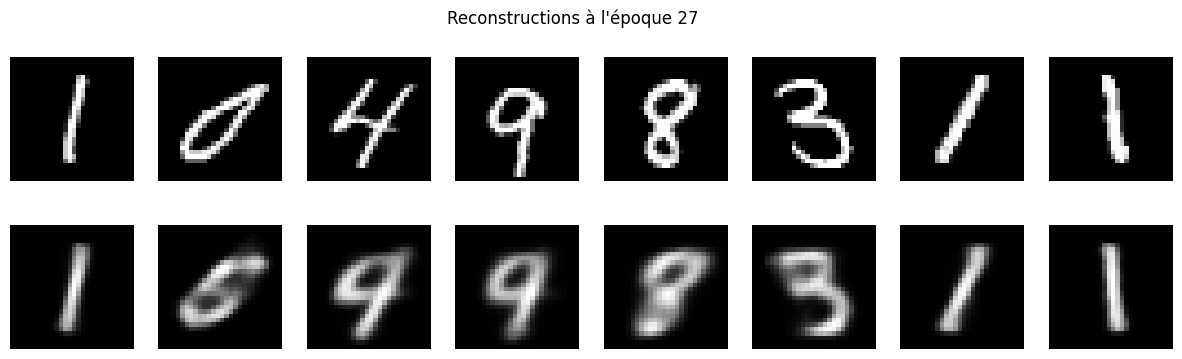

100%|██████████| 938/938 [00:13<00:00, 72.14it/s]


[Epoch 28/50] Loss: 0.2268


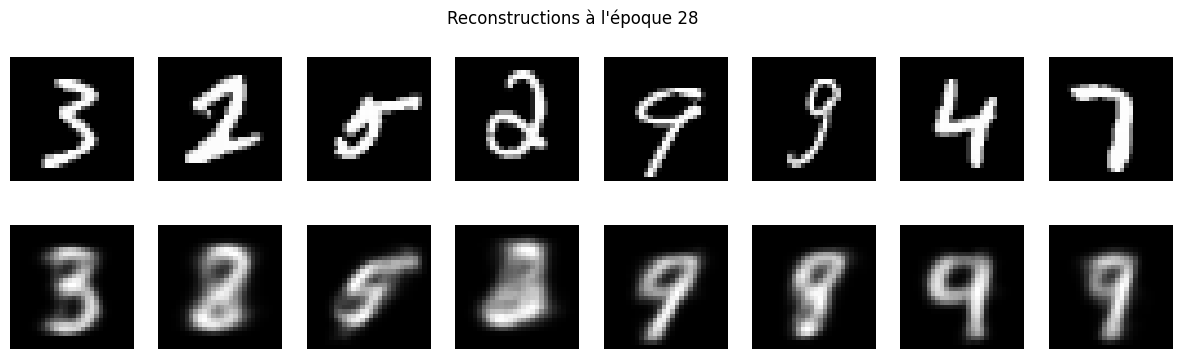

100%|██████████| 938/938 [00:12<00:00, 74.60it/s]


[Epoch 29/50] Loss: 0.2268


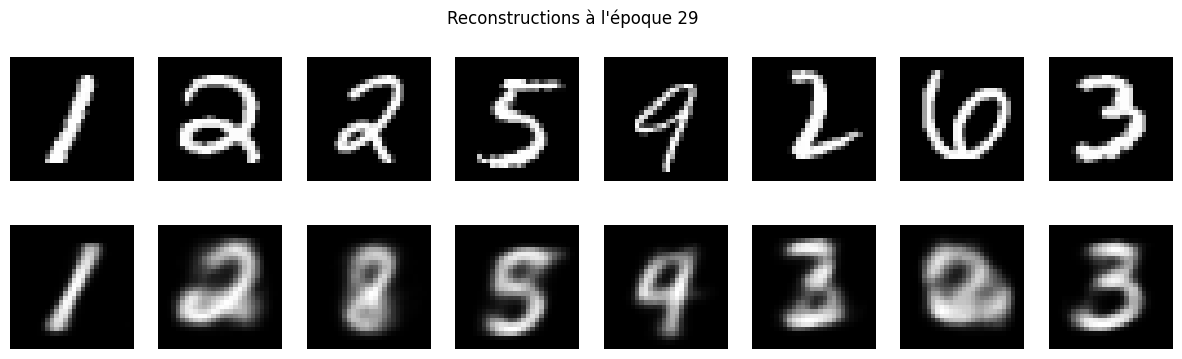

100%|██████████| 938/938 [00:13<00:00, 71.14it/s]


[Epoch 30/50] Loss: 0.2270


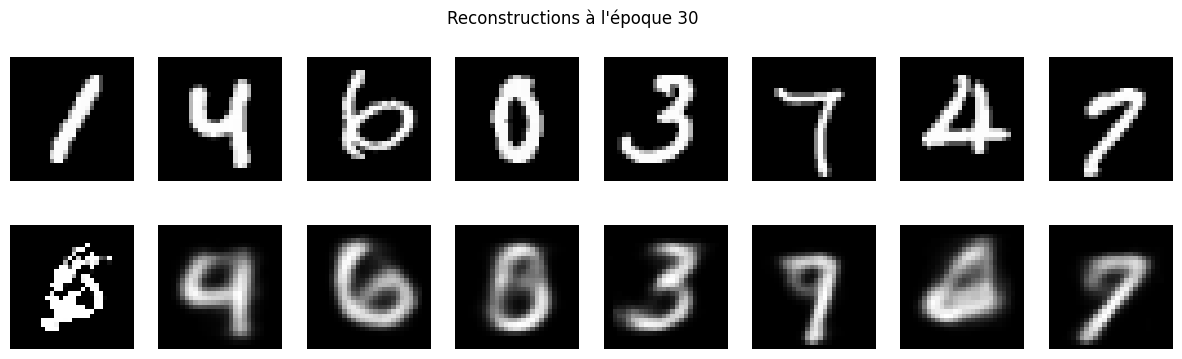

100%|██████████| 938/938 [00:12<00:00, 73.94it/s]


[Epoch 31/50] Loss: 0.2265


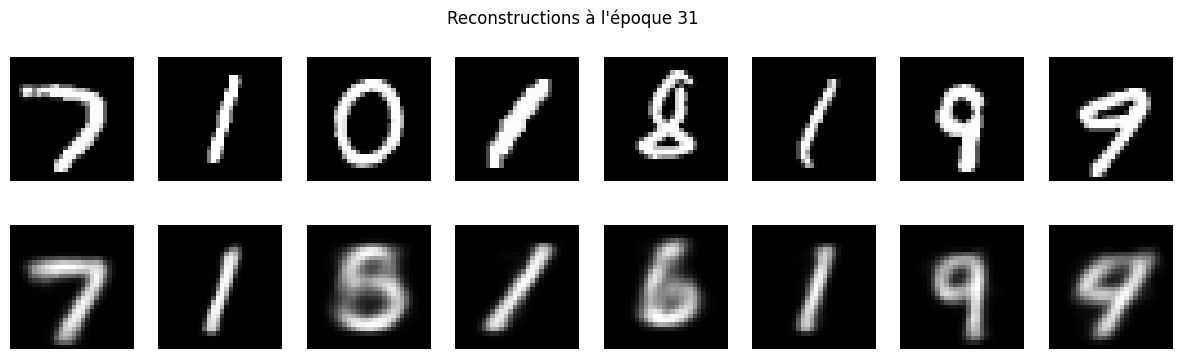

100%|██████████| 938/938 [00:13<00:00, 71.07it/s]


[Epoch 32/50] Loss: 0.2267


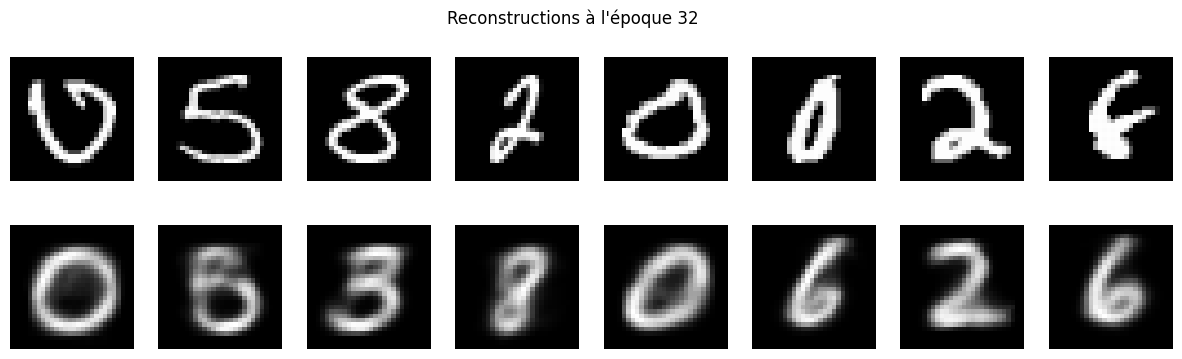

100%|██████████| 938/938 [00:12<00:00, 72.60it/s]


[Epoch 33/50] Loss: 0.2267


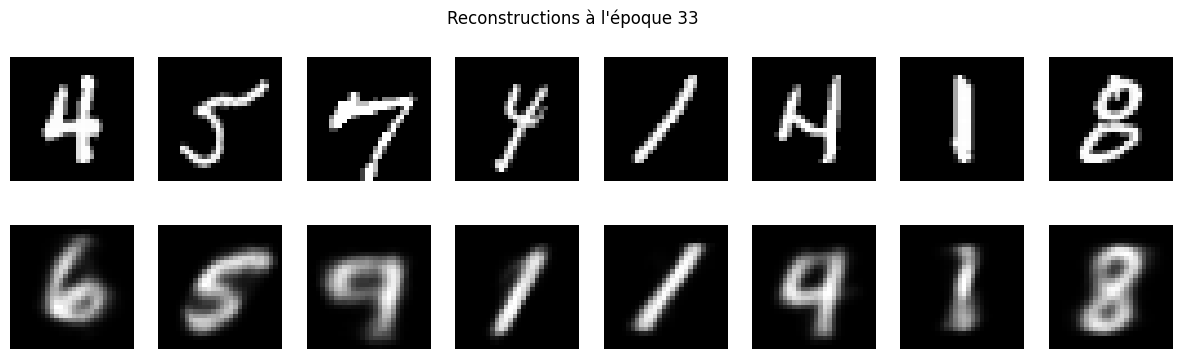

100%|██████████| 938/938 [00:12<00:00, 76.08it/s]


[Epoch 34/50] Loss: 0.2264


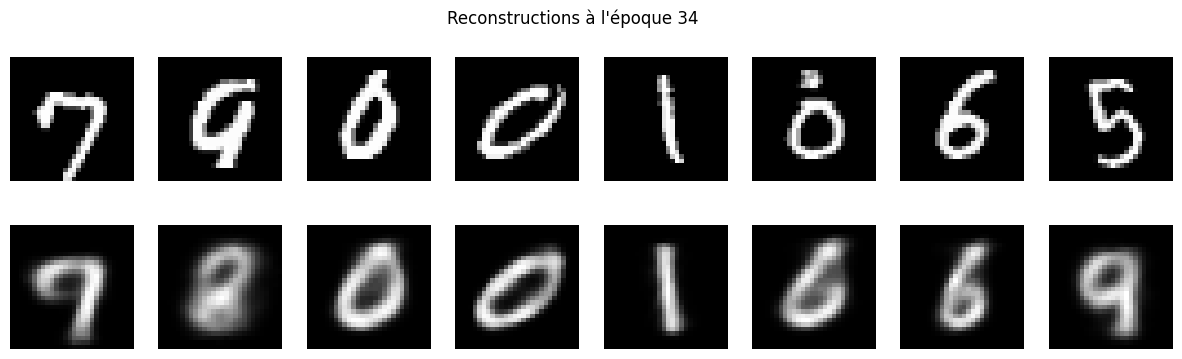

100%|██████████| 938/938 [00:12<00:00, 73.60it/s]


[Epoch 35/50] Loss: 0.2266


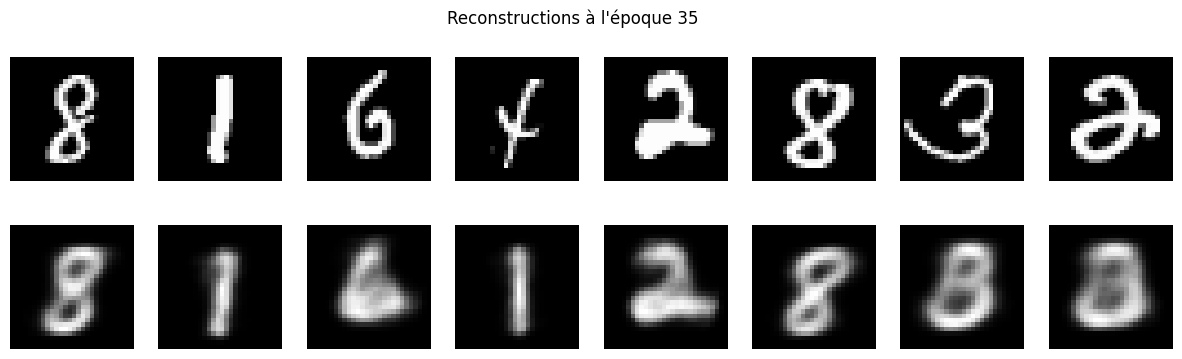

100%|██████████| 938/938 [00:13<00:00, 68.19it/s]


[Epoch 36/50] Loss: 0.2265


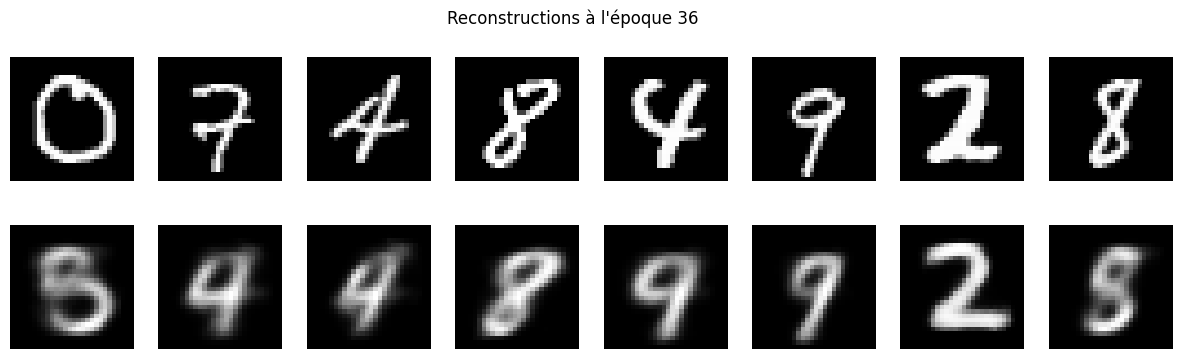

100%|██████████| 938/938 [00:12<00:00, 76.53it/s]


[Epoch 37/50] Loss: 0.2263


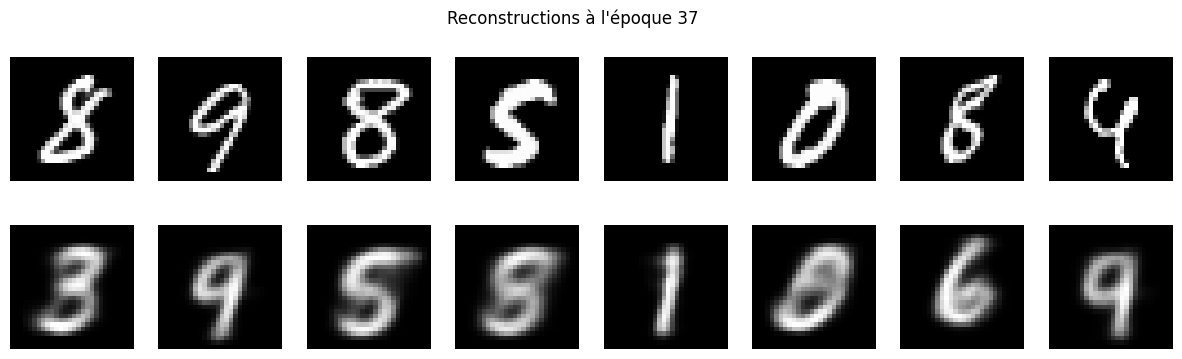

100%|██████████| 938/938 [00:11<00:00, 78.33it/s]


[Epoch 38/50] Loss: 0.2263


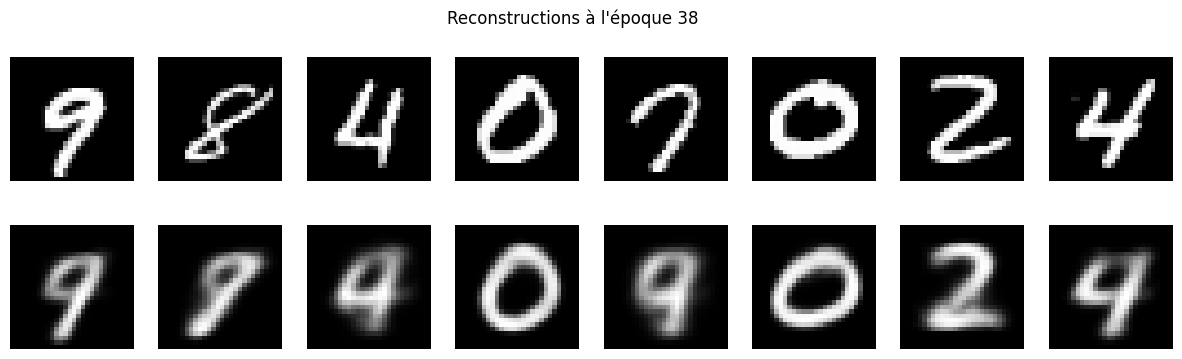

100%|██████████| 938/938 [00:13<00:00, 67.51it/s]


[Epoch 39/50] Loss: 0.2266


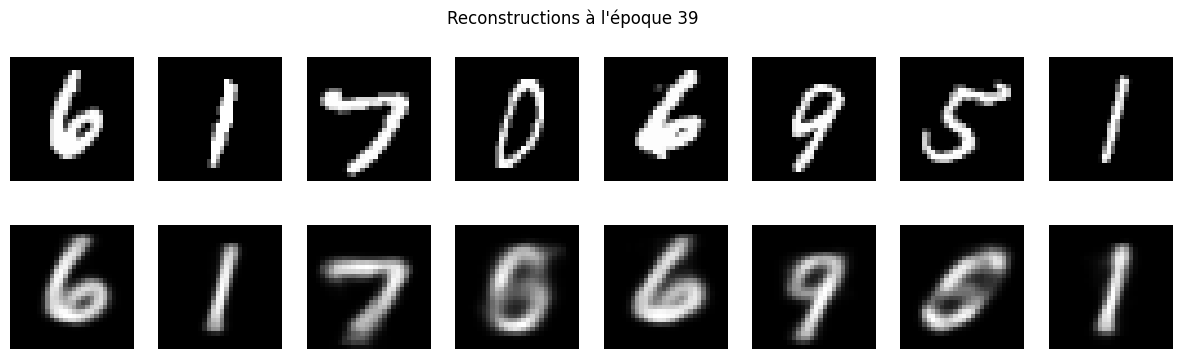

100%|██████████| 938/938 [00:12<00:00, 72.61it/s]


[Epoch 40/50] Loss: 0.2263


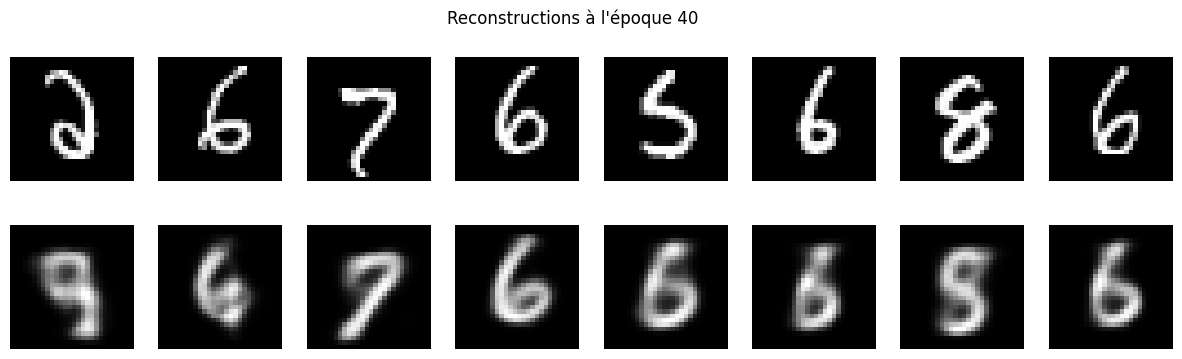

100%|██████████| 938/938 [00:12<00:00, 78.11it/s]


[Epoch 41/50] Loss: 0.2262


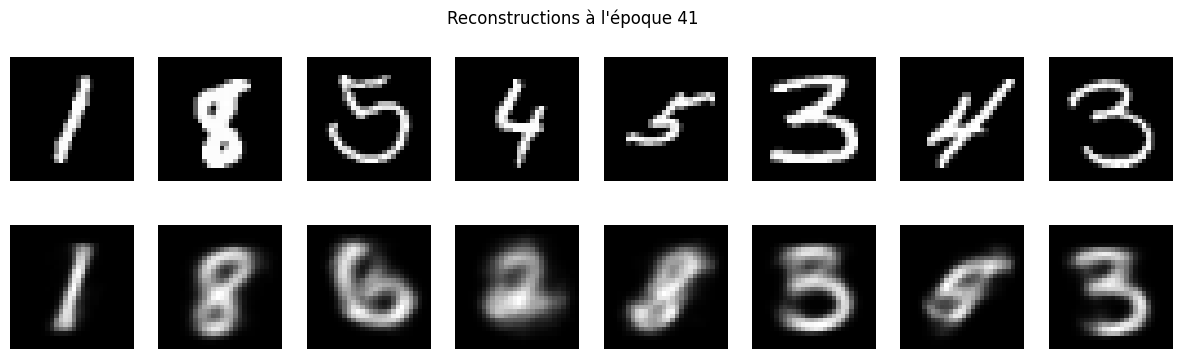

100%|██████████| 938/938 [00:11<00:00, 78.35it/s]


[Epoch 42/50] Loss: 0.2262


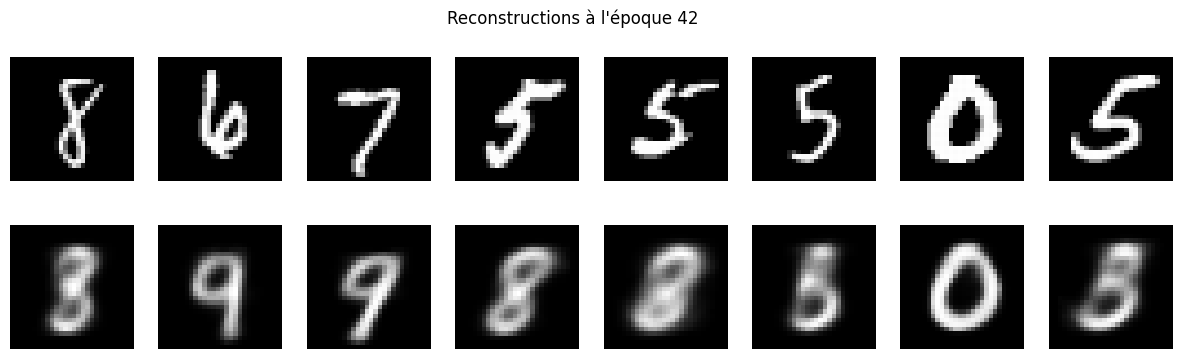

100%|██████████| 938/938 [00:14<00:00, 63.49it/s]


[Epoch 43/50] Loss: 0.2262


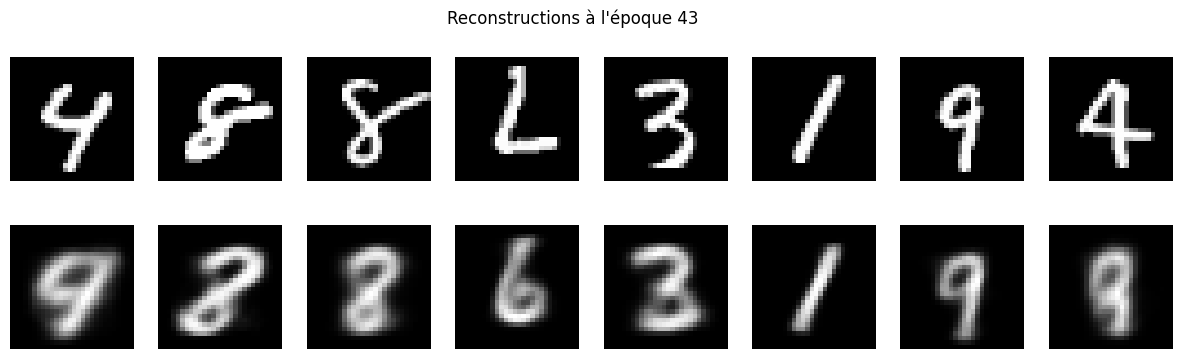

100%|██████████| 938/938 [00:12<00:00, 74.69it/s]


[Epoch 44/50] Loss: 0.2264


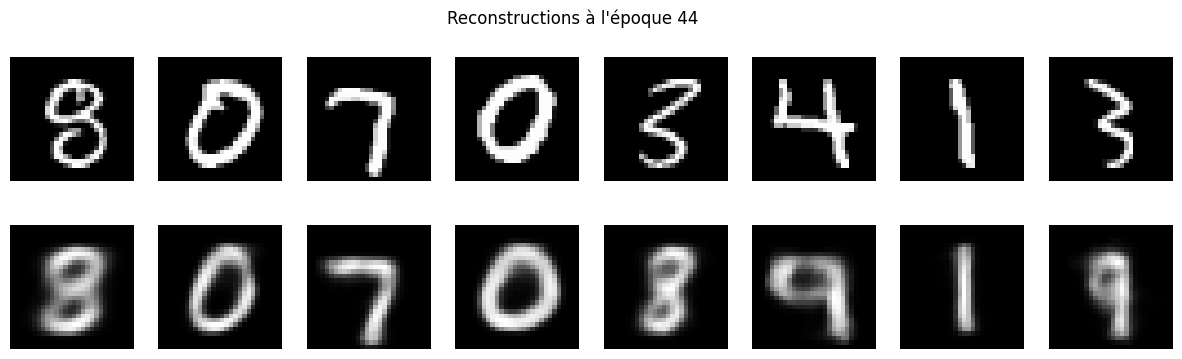

100%|██████████| 938/938 [00:13<00:00, 67.84it/s]


[Epoch 45/50] Loss: 0.2260


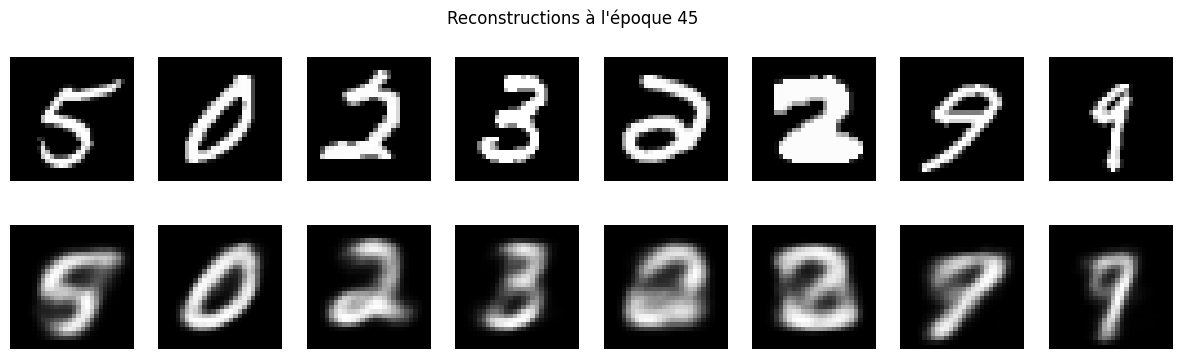

100%|██████████| 938/938 [00:12<00:00, 73.70it/s]


[Epoch 46/50] Loss: 0.2260


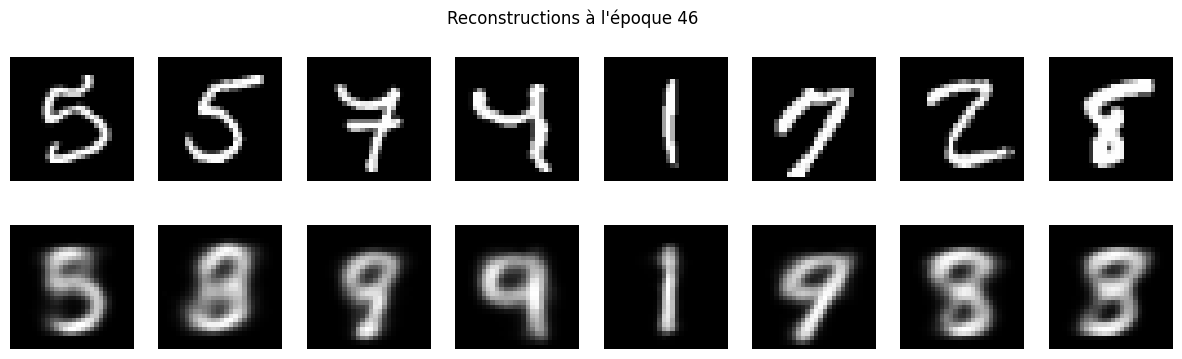

100%|██████████| 938/938 [00:11<00:00, 79.81it/s]


[Epoch 47/50] Loss: 0.2261


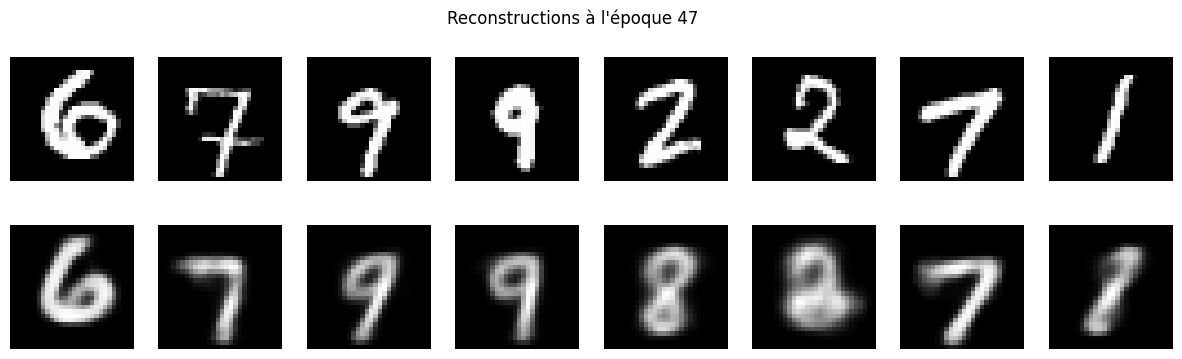

100%|██████████| 938/938 [00:11<00:00, 79.69it/s]


[Epoch 48/50] Loss: 0.2261


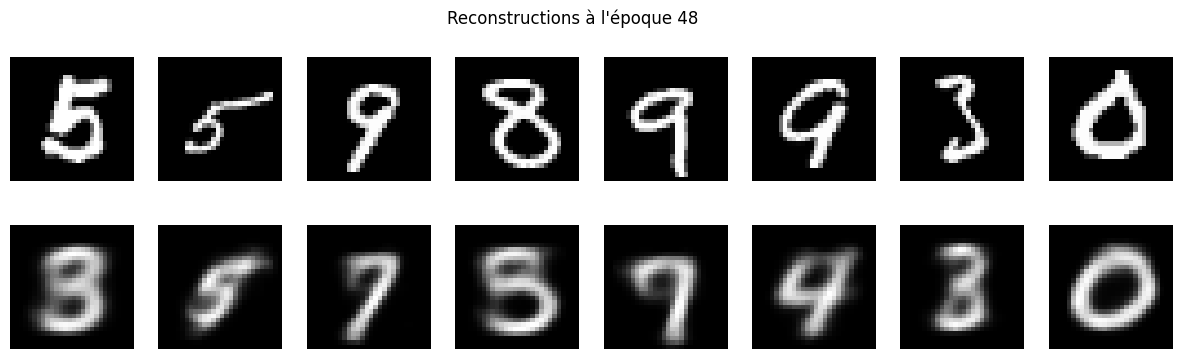

100%|██████████| 938/938 [00:11<00:00, 78.72it/s]


[Epoch 49/50] Loss: 0.2260


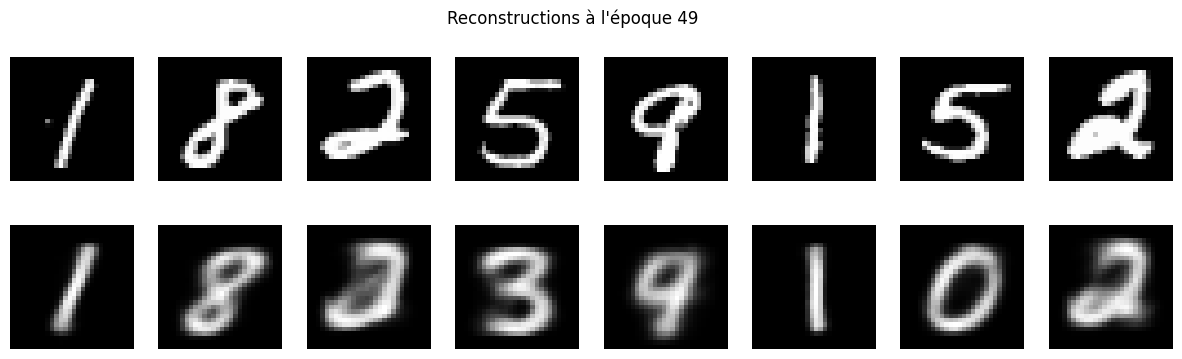

100%|██████████| 938/938 [00:14<00:00, 65.07it/s]


[Epoch 50/50] Loss: 0.2262


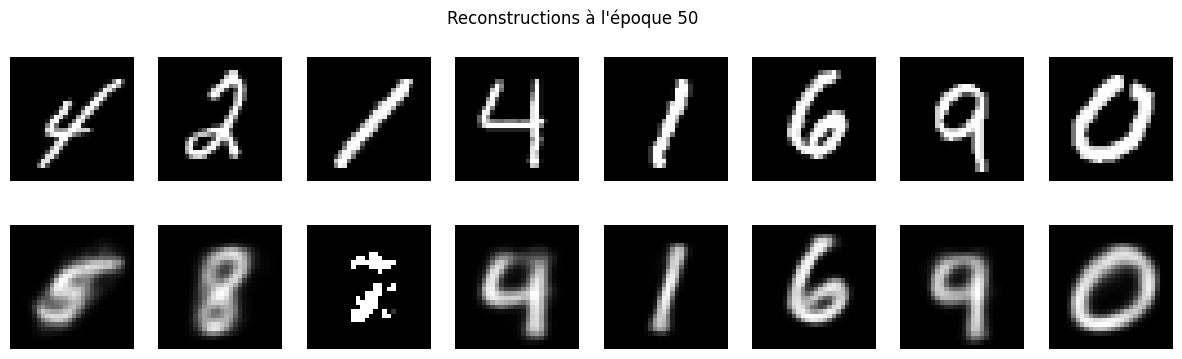

In [28]:
optimizer = optim.Adam([
    {'params': vae.encoder.parameters(), 'lr': 1e-3},
    {'params': vae.decoder.parameters(), 'lr': 1e-2},
])



for epoch in range(epochs):
    total_loss = 0
    for images, _ in tqdm(dataloader):
        images = images.to(device)

        recon_images, mu, logvar = vae(images)

        loss = vae_loss(recon_images, images, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    writer.add_scalar("Loss/Total", total_loss / len(dataloader), epoch)
    print(f"[Epoch {epoch + 1}/{epochs}] Loss: {total_loss / len(dataloader):.4f}")

    visualize_reconstruction(vae, dataloader, epoch)

writer.close()



In [29]:
model_path = "vae_mnist.pth"
torch.save(vae.state_dict(), model_path)
print(f"Modèle PyTorch sauvegardé à : {model_path}")

Modèle PyTorch sauvegardé à : vae_mnist.pth


In [31]:
%pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 11.4 MB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/Users/antoinebendafi/Sites/localhost/A5/spe-ia-machine-learning/vae_env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch.onnx
import os

device = "cpu" 
vae = torch.nn.Identity() 
onnx_filename = "vae_mnist.onnx"


target_directory = os.path.join(os.getcwd(), "models")
os.makedirs(target_directory, exist_ok=True)
onnx_path = os.path.join(target_directory, onnx_filename)

dummy_input = torch.randn(1, 1, 28, 28).to(device) 
torch.onnx.export(
    vae,
    dummy_input,
    onnx_path,
    export_params=True,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
)
print(f"Modèle exporté en ONNX à : {onnx_path}")


Modèle exporté en ONNX à : /Users/antoinebendafi/Sites/localhost/A5/spe-ia-machine-learning/model/public/vae_mnist.onnx


In [ ]:
import os
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


transform = transforms.Compose([
    transforms.ToTensor(),
])


batch_size = 64
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


data_iter = iter(dataloader)
images, _ = next(data_iter)
sample_image = images[0].squeeze().numpy() 


output_dir = "input_images_vae"
os.makedirs(output_dir, exist_ok=True)

image_path = os.path.join(output_dir, "original_image.png")


plt.imsave(image_path, sample_image, cmap="gray")

print(f"Image sauvegardée à : {image_path}")


Image sauvegardée à : input_images_vae/original_image.png
